In [1]:
from import_data import *
from cleaning import *
import datetime
from gradient_boost import *
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble.partial_dependence import plot_partial_dependence,partial_dependence
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score,roc_auc_score,roc_curve
from sklearn.ensemble import GradientBoostingClassifier
from model import *

In [2]:
now = datetime.datetime.now()
this_year = now.year
this_year
salary = get_data('data/salary.p')
stats = get_data('data/stats.p')
free_agents = get_data('data/free_agents.p')
add_features(stats)
final_data = combine_data(salary,stats,free_agents)
final_data = cleaning(final_data)
final_data['Type'] = final_data['Type'].apply(lambda x: 'RFA' if x == 'CO' else x).apply(lambda x: 'UFA' if x == 'PO' else x)
dummies_data = pd.get_dummies(final_data,columns=['Type','Pos.'],drop_first=True)
fa_this_year = dummies_data[dummies_data['Year']==this_year]
final_data1 = dummies_data[dummies_data['Year']!=this_year]
X = final_data1.drop(['Churn','Year','Salary'],axis=1)
y = final_data1['Churn']
X1, x_val, y1, y_val = train_test_split(X,y,test_size=0.1)
X_train, X_test, y_train, y_test = train_test_split(X1,y1)

In [3]:
# gbc = GradientBoostingClassifier()
# gbc.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [17]:
# probs = gbc.predict_proba(X_test)[:, 1]
# preds = get_preds(probs,y_test)

/Users/MSteele/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:
# f1_score(y_test,preds)

0.8789571694599628

In [19]:
# sum(preds==y_test)/len(y_test)

0.796875

In [21]:
# params = {'learning_rate':[0.001,0.005,0.01,0.05,0.1,0.2],
#           'n_estimators':[25,50,75,100,150,200,250,300,350],
#           'max_depth':[2,5,8,10,12,15],
#           'max_features':[None,'sqrt'],
#           'subsample':[0.25,0.5,0.75,1]}
# gbc = GradientBoostingClassifier()
# gs = GridSearchCV(gbc,param_grid=params,scoring='roc_auc',cv=3).fit(X_train,y_train)
# gs.best_params_

/Users/MSteele/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'learning_rate': 0.01,
 'max_depth': 2,
 'max_features': None,
 'n_estimators': 300,
 'subsample': 0.5}

In [4]:
gbc_gs = GradientBoostingClassifier(learning_rate=0.01,max_depth=2,n_estimators=300,subsample=0.5)
gbc_gs.fit(X_train,y_train)
probs_gs = gbc_gs.predict_proba(X_test)[:, 1]
thresh,preds_gs = get_preds(probs_gs,y_test)
f1_score(y_test,preds_gs),sum(preds_gs==y_test)/len(y_test)

/Users/MSteele/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.8840864440078585, 0.815625)

In [42]:
probs_val_set = gbc_gs.predict_proba(x_val)[:,1]
preds_val_set = (probs_val_set>thresh).astype(int)
f1_score(y_val,preds_val_set),sum(preds_val_set==y_val)/len(preds_val_set)

(0.8755364806866952, 0.7972027972027972)

In [23]:
roc_auc_score(y_test,probs_gs)

0.7638822083266528

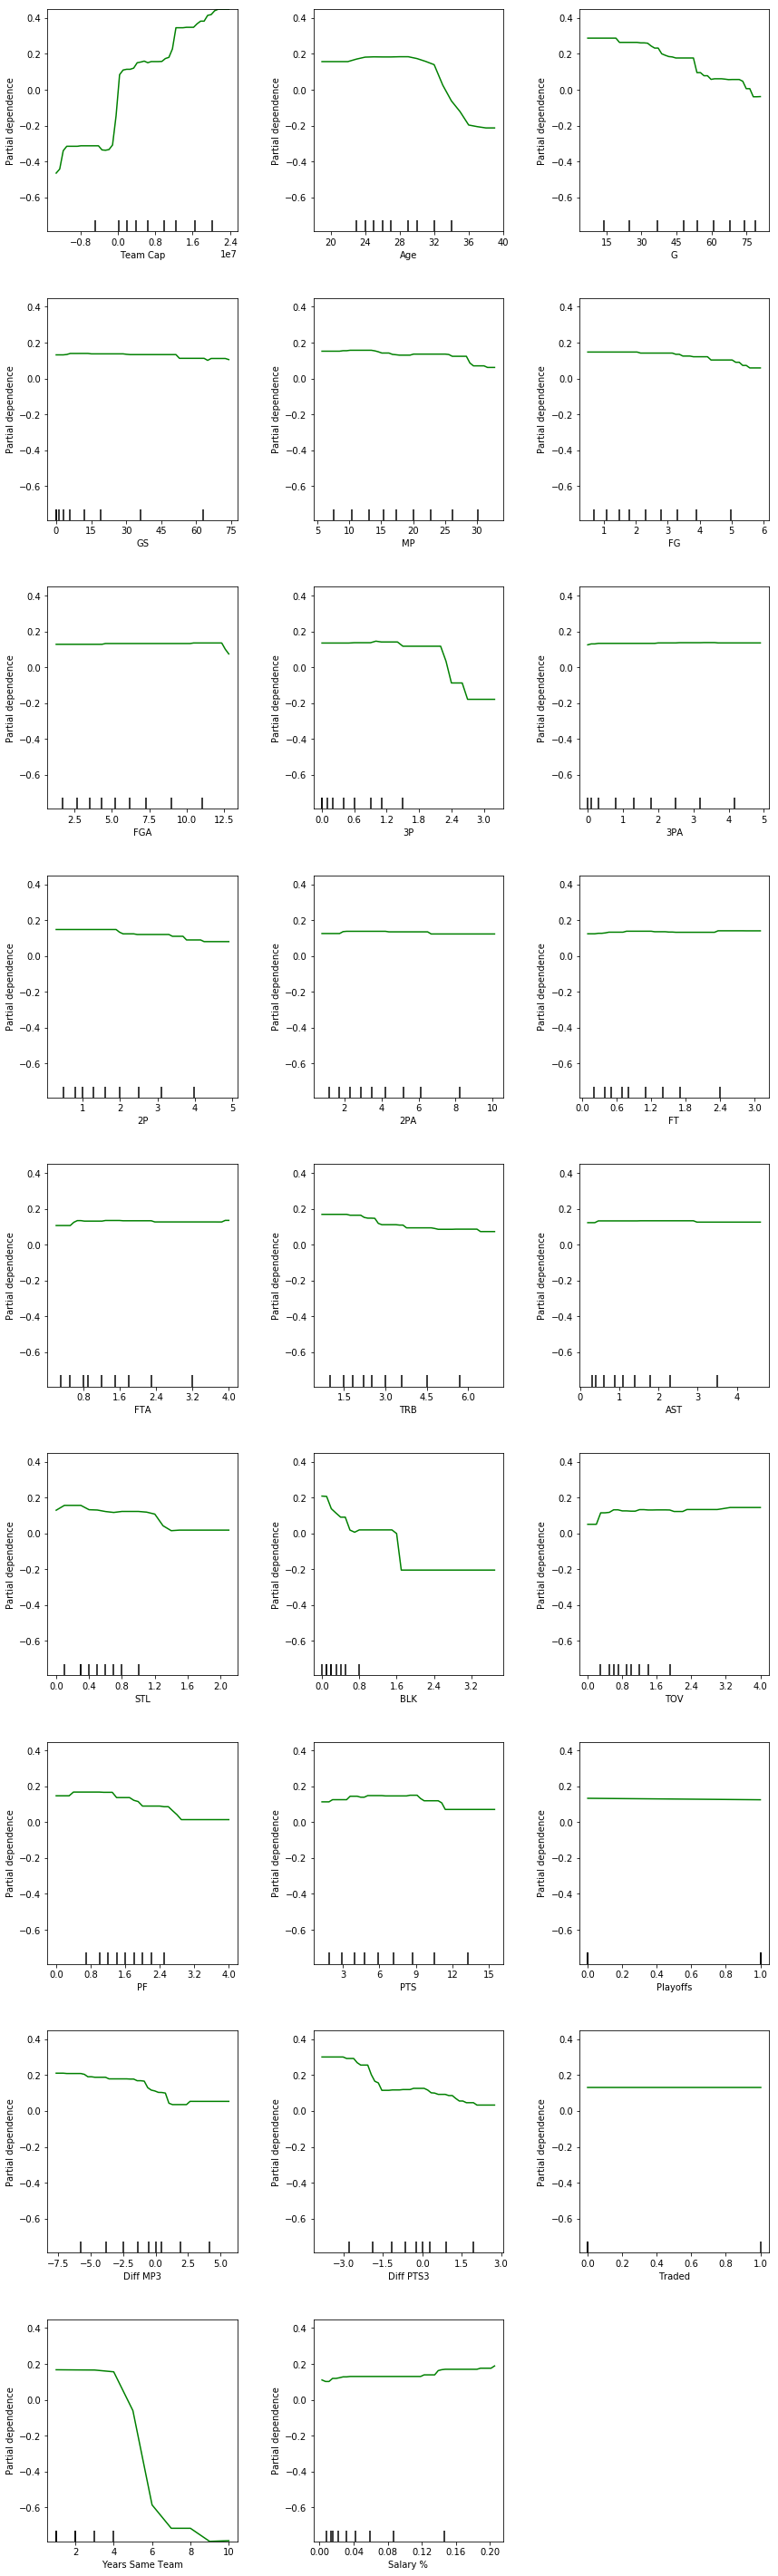

In [47]:
fig , axs = plot_partial_dependence(gbc_gs, X_train.values, range(26),
                                   feature_names=X_train.columns,
                                    grid_resolution=50,figsize=(13,8))
plt.subplots_adjust(top=5)
#plt.savefig('img/cluster2_important_depend.png')

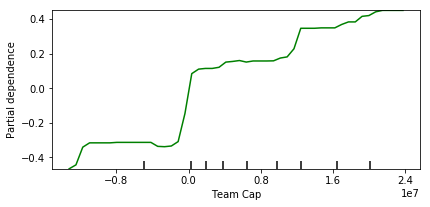

In [51]:
fig , axs = plot_partial_dependence(gbc_gs, X_train.values, [0],
                                   feature_names=X_train.columns,
                                    grid_resolution=50)
plt.savefig('img/team_cap_depend.png')

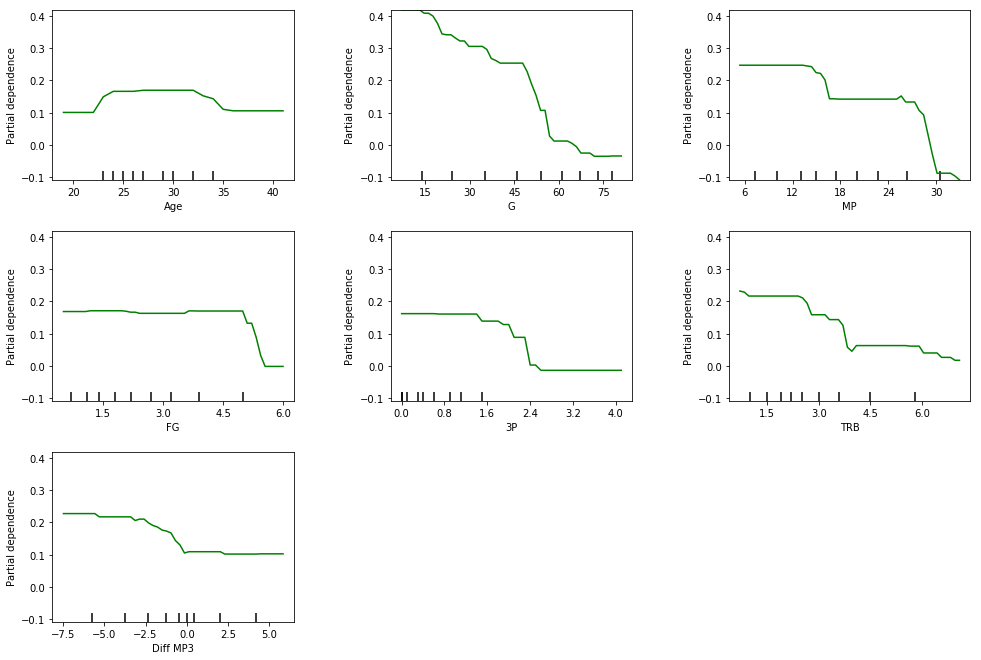

In [37]:
fig , axs = plot_partial_dependence(gbc_gs, X_train.values, [1,2,4,5,7,13,21],
                                   feature_names=X_train.columns,
                                    grid_resolution=50,figsize=(15,10))
plt.subplots_adjust(top=1)
plt.savefig('img/part_depend.png')

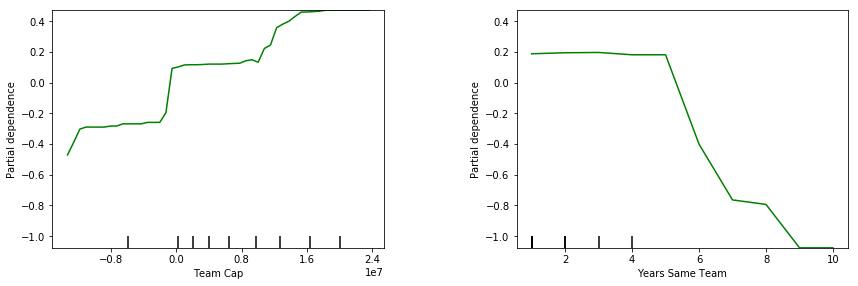

In [42]:
fig , axs = plot_partial_dependence(gbc_gs, X_train.values, [0,24],
                                   feature_names=X_train.columns,
                                    grid_resolution=50,figsize=(13,6))
plt.savefig('img/part_depend2.png')

In [9]:
fa_this_year['Playoffs'] = 1
X_this = fa_this_year.drop(['Churn','Year','Salary'],axis=1)
this_year_probs = gbc_gs.predict_proba(X_this)
this_year_preds = (this_year_probs[:,1]>thresh).astype(int)

/Users/MSteele/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [19]:
this_year_final = pd.concat([pd.Series(fa_this_year.index),pd.Series(this_year_probs[:,1]),pd.Series(this_year_preds)],axis=1)
this_year_final.rename({0:'Player',1:'Probability',2:'Prediction'},axis=1,inplace=True)
this_year_final.set_index('Player',inplace=True)

In [35]:
players_staying = this_year_final[this_year_final['Prediction']==0]
players_staying

,Probability,Prediction
Player,,
Hassan Whiteside,0.570188,0
Paul Millsap,0.347734,0
Rodney McGruder,0.394863,0
Dwyane Wade,0.340479,0
Udonis Haslem,0.487416,0
Kawhi Leonard,0.582944,0
Tomas Satoransky,0.427694,0
Quinn Cook,0.571993,0
Wayne Selden,0.570431,0


In [34]:
players_leaving = this_year_final[this_year_final['Prediction']==1]
players_leaving[150:]

,Probability,Prediction
Player,,
Brandon Sampson,0.657328,1
Alex Caruso,0.601299,1
Marcus Derrickson,0.631604,1
Davon Reed,0.649716,1
Brandon Goodwin,0.696698,1
Shake Milton,0.683755,1
Joe Chealey,0.697909,1
Theo Pinson,0.715588,1
Daryl Macon,0.666741,1
